In [49]:
import os
import pandas as pd

# Discovery

Now , we'll use our trained model on a different/unsen city, hoping to find the stadiums within.

for that, we'll first extract features for each of the tiles and then feed this features to our trained model.

In [134]:
xs = os.listdir('tiles/17/',)

In [138]:
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk('tiles/17/'):
    for file in f:
        if '.jpg' in file:
            files.append(os.path.join(r, file))

In [5]:
import math
def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xoffset = (lon_deg + 180.0) / 360.0 * n
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    yoffset = (1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n
    
    return  (xoffset,yoffset)
import math
def num2deg(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)

we traverse each tile and extract its representation using resnet, as we did with the training set

In [6]:
from keras.applications import resnet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
import numpy as np


model = resnet50.ResNet50(weights='imagenet', include_top=False)

def extract_features(img_path):
    
    img = image.load_img(img_path, target_size=(256, 256))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features.flatten()


Using TensorFlow backend.
/Users/dnul/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [110]:
from keras.models import load_model
resnet_stadium_classifier = load_model('resnet+dense.hdf5')

def predict_is_stadium(features):
    return resnet_stadium_classifier.predict(features)

In [ ]:
# collect tile features , this can take a while
features_array = []
all_files = list(files)
current_files= all_files
while len(current_files)>0:
    for file in current_files[0:100]:
        features_array.append(extract_features(file))
    current_files = current_files[100:]
    print(len(current_files))

In [75]:
import pandas as pd
fa_df = pd.DataFrame.from_records(features_array)

we save extracted features for re-use


In [76]:
# we save extracted features for re-use
fa_df.to_csv('fa_df.csv')

In [88]:
cordoba_features_df = pd.read_csv('extracted_features_cordoba.csv',dtype='float32')

In [155]:
files = pd.read_csv('files.csv')

In [156]:
files = files[files.columns[1]]

In [89]:
cordoba_features_df= cordoba_features_df[cordoba_features_df.columns[1:]]

In [112]:
features_array = cordoba_features_df.values

In [117]:
np.array(features_array).shape

(21733, 2048)

so we have ~21k tile images, each with a 2048-dim feature vector. 
using our trained classifier we'll try to predict which are most likely to contain stadiums

In [175]:
features_array[10]

array([ 0.        ,  0.00362931,  0.05580929, ...,  0.72546124,
        0.00283648,  0.        ], dtype=float32)

In [119]:
predict_is_stadium(features_array)[10]

array([ 0.00206225], dtype=float32)

In [140]:
predictions = resnet_stadium_classifier.predict(np.array(features_array))

pd.Da

let's pick the top predictions

In [191]:
pd.DataFrame.from_records(predictions).quantile(0.999)

0    0.381543
Name: 0.999, dtype: float64

In [194]:
threshold = 0.35

In [195]:
len(predictions[predictions>threshold])

27

In [177]:
from IPython.display import Image
from IPython.core.display import HTML 

def get_stadium_image(lat,lng,zoom):
    x,y = deg2num(-lat,lng,zoom)
    filename = 'tiles/%s/%s/%s.jpg' % (zoom,int(x),int(y))
    if filename in files:
        return './'+filename
    return None


In [197]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
def show_image(path):
    image = mpimg.imread(path)
    plt.imshow(image)
    plt.figure()


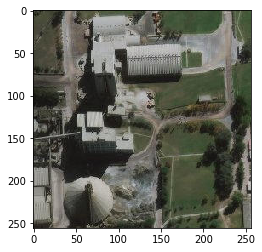

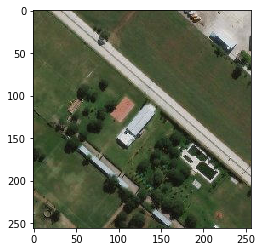

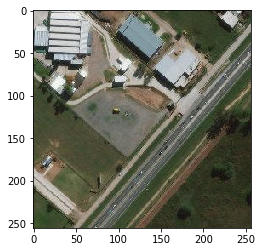

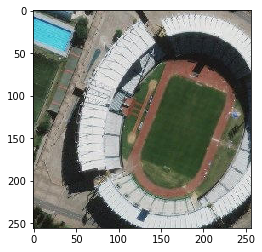

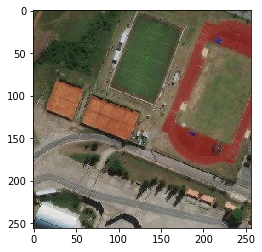

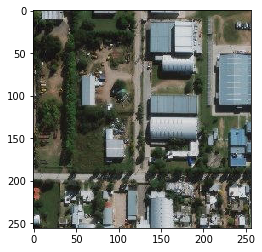

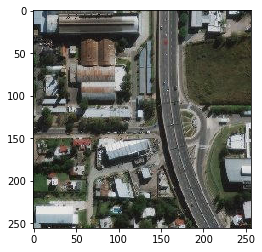

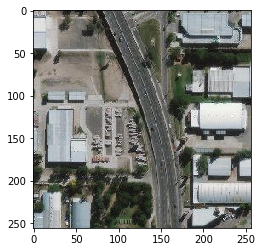

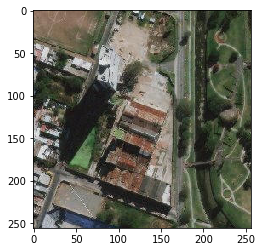

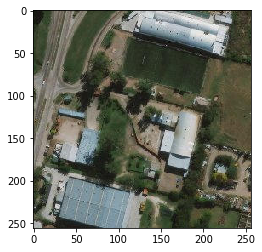

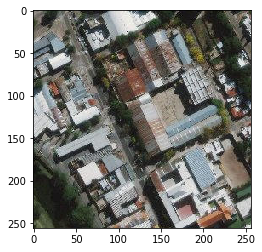

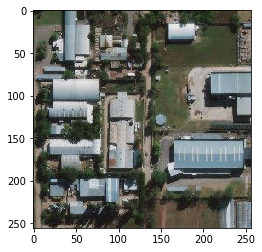

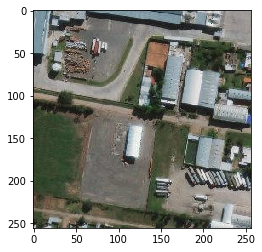

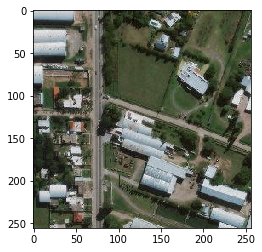

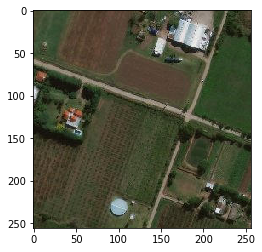

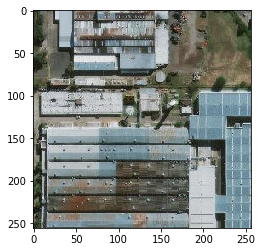

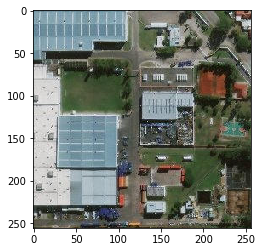

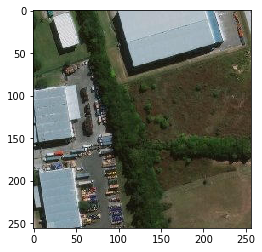

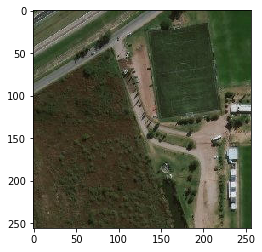

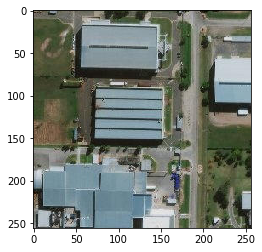

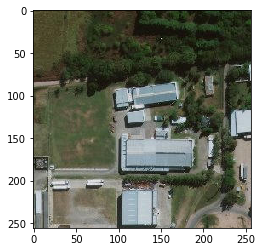

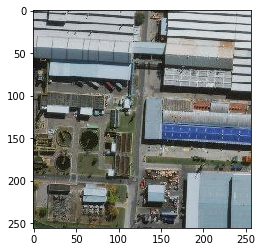

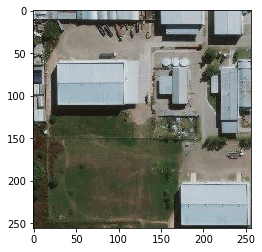

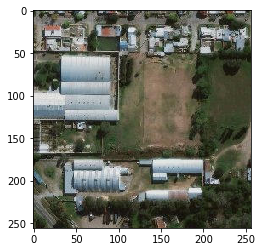

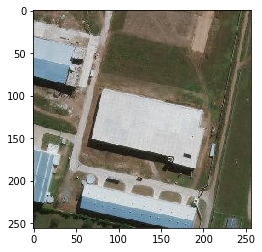

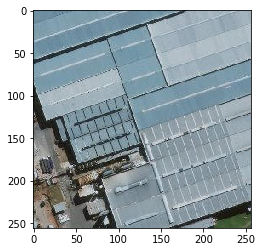

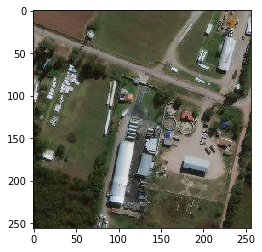

<Figure size 432x288 with 0 Axes>

In [198]:
for i,x in enumerate(predictions):
    if x>threshold:
        show_image(files[i])

# Findings

Picking the top 37 from the output of the classifier, we discover some images of stadiums / soccer fields amongst a majority of false positives. It's important to note that there are some images which do not correspond to stadiums but resemble very much to a soccer field.  some notes:

* The trained model is able to find stadiums in unseen samples in the top picks. partial success
* There are lot of false positives, the images we're tagging as positive samples also show the surroundings of the stadium which are introducing noise.
* As a side-effect the model seem to have learned the looks of a soccer field
